## Explore the data with some EDA

Explore the data with some EDA
First, let's explore the data. Any time we begin a machine learning (ML) project, we need to first do some exploratory data analysis (EDA) to familiarize ourselves with the data. This includes things like:

   * raw data plots
   * histograms

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import DataReader
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]

In [2]:
itau = DataReader('ITSA4.SA','yahoo', datetime(2016, 1, 1), datetime(2019,12, 31))
itau.drop(columns=['High','Low', 'Open', 'Close'], inplace=True)
itau = itau.sort_values(by='Date')

In [3]:
bova = DataReader('BOVA11.SA','yahoo', datetime(2016, 1, 1), datetime(2019,12, 31))
bova.drop(columns=['High','Low', 'Open', 'Close'], inplace=True)
bova = bova.sort_values(by='Date')

                Volume  Adj Close
Date                             
2016-01-04  27677128.0   3.999628
2016-01-05  15150905.0   4.066288
2016-01-06  32897139.0   4.102647
2016-01-07  22565155.0   4.042049
2016-01-08  14222784.0   4.042049
               Volume  Adj Close
Date                            
2016-01-04  1709240.0  41.099998
2016-01-05  2419970.0  41.180000
2016-01-06  1386590.0  40.500000
2016-01-07  2545360.0  39.470001
2016-01-08  2731250.0  39.340000


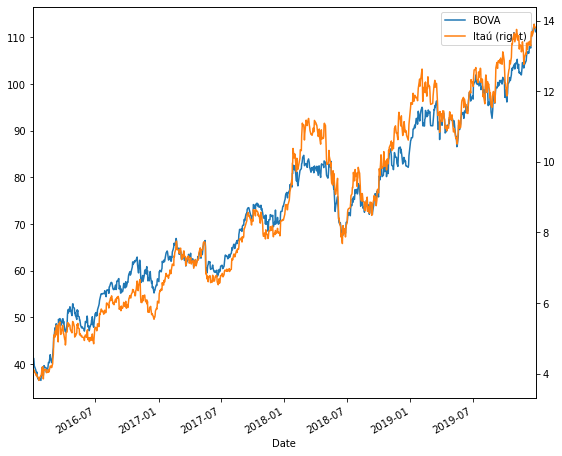

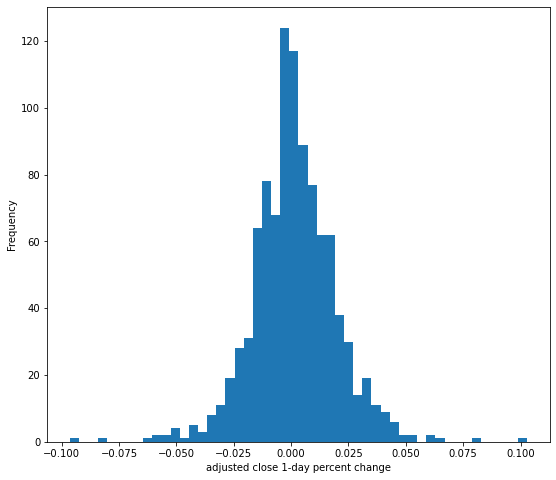

In [4]:
print(itau.head())  # examine the DataFrames
print(bova.head())  # examine the BOVA DataFrame

# Plot the Adj_Close columns for BOVA and Itau
bova['Adj Close'].plot(label='BOVA', legend=True)
itau['Adj Close'].plot(label='Itaú', legend=True, secondary_y=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of Adj_Close for Itau
itau['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

## Correlations

Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. It's commonly assumed our data is normally distributed, which we can "eyeball" from histograms. Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is mean-reverting (bounces around) or trend-following (goes up if it has been going up recently).

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.016418
5d_close_future_pct     -0.016418             1.000000


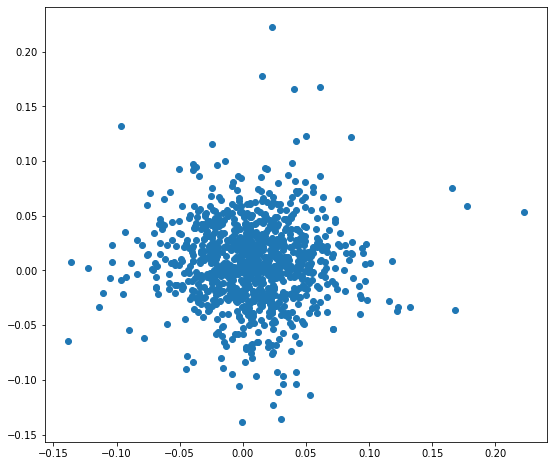

In [5]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
itau['5d_future_close'] = itau['Adj Close'].shift(-5)
itau['5d_close_future_pct'] = itau['5d_future_close'].pct_change(5)
itau['5d_close_pct'] = itau['Adj Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = itau[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(itau['5d_close_pct'], itau['5d_close_future_pct'])
plt.show()

We can see that the change of 5 days is not correlated with the change in the last 5 days!

# Create moving average and RSI features

We want to add historical data to our machine learning models to make better predictions, but adding lots of historical time steps is tricky. Instead, we can condense information from previous points into a single timestep with indicators.

Another common technical indicator is the relative strength index (RSI). This is defined by:

RSI=100 − 100 / (1+RS)

RS = average gain over n periods / average loss over n periods

In [6]:
import talib

In [7]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    itau['ma' + str(n)] = talib.SMA(itau['Adj Close'].values,
                              timeperiod=n) / itau['Adj Close']
    # Create the RSI indicator
    itau['rsi' + str(n)] = talib.RSI(itau['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


# Create features and targets

We almost have features and targets that are machine-learning ready -- we have features from current price changes (5d_close_pct) and indicators (moving averages and RSI), and we created targets of future price changes (5d_close_future_pct). Now we need to break these up into separate numpy arrays so we can feed them into machine learning algorithms.

In [8]:
# Drop all na values
itau = itau.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = itau[feature_names]
targets = itau['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = itau[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000      0.025245 -0.055660  0.046199   
5d_close_pct                    0.025245      1.000000 -0.858622  0.685630   
ma14                           -0.055660     -0.858622  1.000000 -0.860685   
rsi14                           0.046199      0.685630 -0.860685  1.000000   
ma30                           -0.063889     -0.659163  0.868284 -0.942396   
rsi30                          -0.006455      0.521131 -0.696584  0.924286   
ma50                           -0.020502     -0.512149  0.707748 -0.894290   
rsi50                          -0.053352      0.424221 -0.582904  0.820035   
ma200                           0.154241     -0.256645  0.377730 -0.574856   
rsi200                         -0.123803      0.239740 -0.343812  0.550440   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct -0.063889 -0.006455 -0.020502 -0.053352  0.15424

# Check the correlations

Before we fit our first machine learning model, let's look at the correlations between features and targets. Ideally we want large (near 1 or -1) correlations between features and targets. Examining correlations can help us tweak features to maximize correlation (for example, altering the timeperiod argument in the talib functions). It can also help us remove features that aren't correlated to the target.

In [9]:
import seaborn as sns

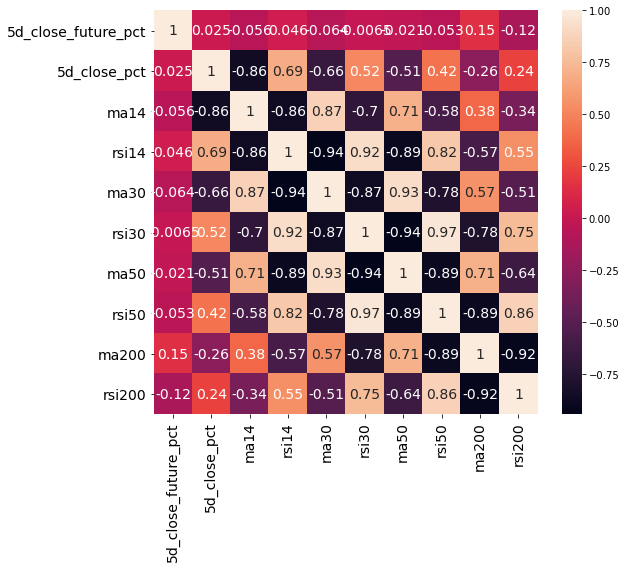

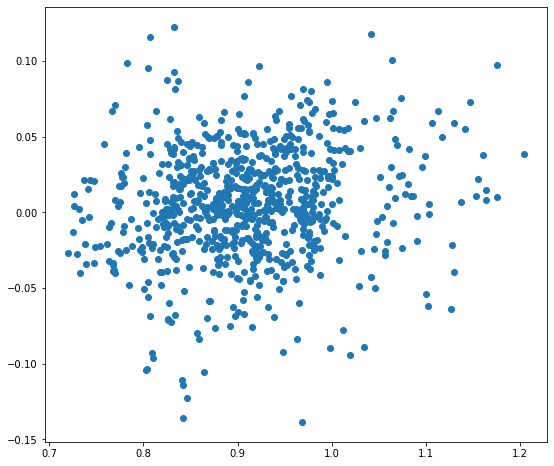

In [10]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True, annot_kws = {"size": 14})
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(itau['ma200'], itau['5d_close_future_pct'])
plt.show()

# Create train and test features

Before we fit our linear model, we want to add a constant to our features, so we have an intercept for our linear model.

We also want to create train and test features. This is so we can fit our model to the train dataset, and evaluate performance on the test dataset. We always want to check performance on data the model has not seen to make sure we're not overfitting, which is memorizing patterns in the training data too exactly.

With a time series like this, we typically want to use the oldest data as our training set, and the newest data as our test set. This is so we can evaluate the performance of the model on the most recent data, which will more realistically simulate predictions on data we haven't seen yet.

In [11]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(790, 10) (671, 10) (119, 10)


# Fit a linear model

We'll now fit a linear model, because they are simple and easy to understand. Once we've fit our model, we can see which predictor variables appear to be meaningfully linearly correlated with the target, as well as their magnitude of effect on the target. Our judgment of whether or not predictors are significant is based on the p-values of coefficients. This is using a t-test to statistically test if the coefficient significantly differs from 0. The p-value is the percent chance that the coefficient for a feature does not differ from zero. Typically, we take a p-value of less than 0.05 to mean the coefficient is significantly different from 0.

In [12]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.095
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     7.694
Date:                 Wed, 22 Jul 2020   Prob (F-statistic):           8.42e-11
Time:                         21:48:19   Log-Likelihood:                 1285.5
No. Observations:                  671   AIC:                            -2551.
Df Residuals:                      661   BIC:                            -2506.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3004      0.194    

# Evaluate our results

Once we have our linear fit and predictions, we want to see how good the predictions are so we can decide if our model is any good or not. Ideally, we want to back-test any type of trading strategy. However, this is a complex and typically time-consuming experience.

A quicker way to understand the performance of our model is looking at regression evaluation metrics like R², and plotting the predictions versus the actual values of the targets. Perfect predictions would form a straight, diagonal line in such a plot, making it easy for us to eyeball how our predictions are doing in different regions of price changes. 

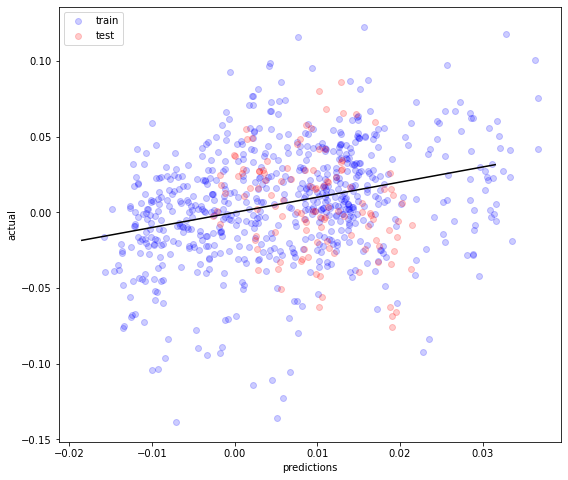

In [13]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

We can see our predictions are ok, but not very good yet. We need non-linearity!